# Основной код

In [1]:
import os
import random
import tqdm
from glob import glob
from IPython.display import display

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader

import albumentations as A

from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
DEFAULT_RANDOM_SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_all_seeds(seed=DEFAULT_RANDOM_SEED):

      random.seed(seed)
      os.environ['PYTHONHASHSEED'] = str(seed)
      np.random.seed(seed)

      torch.manual_seed(seed)
      torch.cuda.manual_seed(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False
      np.random.RandomState(seed)

      print("all seed setted")

# if mode is test_mode:
set_all_seeds(seed=DEFAULT_RANDOM_SEED)

all seed setted


## Свёртка 1

## Свёртка

### Dataset initializing

In [3]:
target_bin_mapper = {3 : 0, 8 : 1}
bin_target_mapper = {0 : 3, 1 : 8}
def preprocess_df(df, mode, image_w):

  if mode == "train":
    new_values = df.apply(lambda x: list((x[1:].values.reshape(image_w, image_w)) / 255), axis=1)
    df["image"] = new_values
    return df.iloc[:, [0, -1]]

  else:
    new_values = df.apply(lambda x: list((x.values.reshape(image_w, image_w)) / 255), axis=1)
    df["image"] = new_values
    return df.iloc[:, -1]

train_path = 'https://github.com/afonsky/DataAnalysisSummerSchool-2024/raw/main/trainYX.zip'
test_path = 'https://github.com/afonsky/DataAnalysisSummerSchool-2024/raw/main/testX.zip'
train_df = pd.read_csv(train_path, compression='zip', index_col='id')
test_df = pd.read_csv(test_path, compression='zip', index_col='id')

train_df = preprocess_df(train_df, mode="train", image_w=32)
test_df = preprocess_df(test_df, mode="test", image_w=32)

In [4]:
full_train = False
apply_augmentations = True

In [5]:
transform1 = A.Compose([
      A.HorizontalFlip(p=0.6),
      A.VerticalFlip(p=0.6),
      A.RandomRotate90(p=0.8)
  ])

transform2 = A.Compose([
    A.Rotate(limit=45, p=1)
])

transform3 = A.Compose([
    A.GaussianBlur(p=1),
])

def split_train_val(data, train_size=1, val_size=0, test_size=0, seed=DEFAULT_RANDOM_SEED):

  np.random.seed(seed)
  if isinstance(data, pd.DataFrame):
    data = data.sample(frac=1).reset_index(drop=True)
  else:
    np.random.shuffle(data)

  data_shape = data.shape[0]

  train_actual_size = int(data_shape * train_size)
  val_actual_size = train_actual_size + int(data_shape * val_size)
  test_actual_size = val_actual_size + int(data_shape * test_size)

  if isinstance(data, pd.DataFrame):

    train = data.iloc[:train_actual_size, :]
    val = data.iloc[train_actual_size:val_actual_size, :]
    test = data.iloc[val_actual_size:test_actual_size, :]

  else:

    train = data[:train_actual_size, :]
    val = data[train_actual_size:val_actual_size, :]
    test = data[val_actual_size:test_actual_size, :]

  return train, None if len(val) == 0 else val, None if len(test) == 0 else test

train_, val_, _ = split_train_val(train_df, train_size=0.8, val_size=0.2)
X_train, y_train, X_val, y_val = train_['image'].values, train_['y'], val_['image'].values, val_['y']

In [6]:
class BaseDataset:
  def __init__(self, X, target=None, target_bin_mapper=target_bin_mapper, image_width=32, test_tta=False):
    self.X = torch.tensor(X).float()
    self.test_tta = test_tta
    self.image_width = image_width
    if target is not None:
      mapper_func = np.vectorize(lambda x: target_bin_mapper[x])
      self.target = torch.tensor(mapper_func(target))
      self.test = False
    else:
      self.test = True

  def __getitem__(self, idx):

    img = self.X[idx]

    if self.test_tta:

      transform1 = A.Compose([
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),
          A.RandomRotate90(p=1)
      ])
      transform2 = A.Compose([A.Rotate(limit=45, p=1)])

      img_transformed_1 = transform1(image=np.array(img))["image"]
      img_transformed_2 = transform2(image=np.array(img))["image"]
      img_transformed_3 = transform1(image=np.array(img))["image"]
      img_transformed_4 = transform2(image=np.array(img))["image"]

      img = (img, img_transformed_1, img_transformed_2, img_transformed_3, img_transformed_4)

    if not self.test:
      target = self.target[idx]
      return img, target
    else:
      return img

  def __len__(self,):
    return self.X.shape[0]


train_dataset = BaseDataset(X=np.array(list(X_train)), target=y_train, test_tta=False,)
val_dataset = BaseDataset(X=np.array(list(X_val)), target=y_val, test_tta=False)
test_dataset = BaseDataset(X=np.array(list(test_df.values)), test_tta=False)

### Batching

In [7]:
def init_loaders(
              train_dataset,
              val_dataset=None,
              test_dataset=None,
              batch_size=32,
              num_workers=None,
              pin_memory=None,
              seed=DEFAULT_RANDOM_SEED,
              device=torch.device("cpu")
              ):

    loaders = {"train_loader" : None, "val_loader" : None, "test_loader" : None}

    set_all_seeds(seed)
    generator = torch.Generator().manual_seed(seed)
    train_loader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers if (num_workers != None and device == torch.device("cuda")) else 0,
                                  pin_memory=pin_memory if (num_workers != None and device == torch.device("cuda")) else False,
                                  shuffle=True,
                                  generator=generator
                                  )
    loaders["train_loader"] = train_loader

    if val_dataset != None:
      val_loader = DataLoader(val_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers if (num_workers != None and device == torch.device("cuda")) else 0,
                                  pin_memory=pin_memory if (num_workers != None and device == torch.device("cuda")) else False,
                                  shuffle=False,
                                  generator=generator
                                  )
      loaders["val_loader"] = val_loader

    if test_dataset != None:
      test_loader = DataLoader(test_dataset,
                                   batch_size=batch_size,
                                   num_workers=num_workers if (num_workers != None and device == torch.device("cuda")) else 0,
                                   pin_memory=pin_memory if (num_workers != None and device == torch.device("cuda")) else False,
                                   shuffle=False,
                                   generator=generator
                                   )
      loaders["test_loader"] = test_loader

    return loaders

### Класс Модели

#### свёртки

In [8]:
set_all_seeds(DEFAULT_RANDOM_SEED)

class CNNPro(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 5, padding_mode='replicate')
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 64, 5, padding_mode='replicate')
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 64, 3, padding_mode='replicate')
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 64, 3, padding_mode='replicate')
        self.bn4 = nn.BatchNorm2d(64)


        self.fc1 = nn.Linear(1024, 128)
        # self.fc2 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(128, 1)

        # self.bn = nn.BatchNorm1d(2048)

        self.dropout = nn.Dropout(0.25)
        self.pool = nn.MaxPool2d(2, padding=0)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = self.bn1(x)


        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = self.bn3(x)


        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        # print(x.shape)
        x = self.pool(x)
        # print(x.shape)
        x = self.dropout(x)
        # print(x.shape)


        x = torch.flatten(x, 1) # flatten all dimensions except batch


        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def get_embedding(self, x):

        x = x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = self.bn1(x)


        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = self.bn3(x)


        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        # print(x.shape)
        x = self.pool(x)
        # print(x.shape)
        x = self.dropout(x)
        # print(x.shape)


        x = torch.flatten(x, 1) # flatten all dimensions except batch


        x = self.fc1(x)

        return x

class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = ((1 - pt) ** self.gamma) * BCE_loss
        return torch.mean(F_loss)


all seed setted


#### Vit

In [ ]:
!pip install einops

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch.nn.modules.linear import Linear

import torchvision.transforms as transforms

In [ ]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

img_size=32

train_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

train_data_ = CIFAR10(download=True,root="./cifar10",transform=train_transforms)
test_val_data_ = CIFAR10(root="./cifar10",train = False,transform=test_transforms)

100%|██████████| 170498071/170498071 [00:01<00:00, 95054863.47it/s] 


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int = 768, num_patches: int = None, dropout: float = 0.):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, d_model))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, n):
        x = x + self.pos_embed[:, :(n+1)]
        x = self.dropout(x)
        return x

class Norm(nn.Module):
    def __init__(self, d_model: int = 768, next_layer: nn.Module = None):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.next_layer = next_layer
    def forward(self, x: torch.Tensor, **kwargs):
        x = self.norm(x)
        return self.next_layer(x, **kwargs)

class FeedForward(nn.Module):
    def __init__(self, d_model: int = 768, d_mlp: int = 3072, dropout: float = 0.):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(d_model, d_mlp),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_mlp, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor):
        return self.layers(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int = 768, n_head: int = 12, dropout: float = 0.):
        super().__init__()
        self.d_model = d_model
        self.n_head = n_head
        self.dropout = nn.Dropout(dropout)

        d_head = d_model // n_head
        project_out = not (n_head == 1 and d_head == d_model)

        self.scale = d_head ** -0.5
        self.softmax = nn.Softmax(dim = -1)
        self.w_qkv = nn.Linear(d_model, d_model * 3, bias = False)

        self.fc_out = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.n_head
        qkv = self.w_qkv(x).chunk(3, dim = -1)
        queries, keys, values = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        # Compute Attention score
        scores = torch.einsum('b h i d, b h j d -> b h i j', queries, keys) * self.scale
        attention = self.softmax(scores)

        x = torch.einsum('b h i j, b h j d -> b h i d', attention, values)
        x = rearrange(x, 'b h n d -> b n (h d)')

        return x

class ViT(nn.Module):
    def __init__(self, img_size: int = 256, patch_size: int = 16,
                num_class: int = 1000, d_model: int = 768, n_head: int = 12,
                n_layers:int = 12, d_mlp: int = 3072, channels: int = 3,
                dropout: float = 0., pool: str = 'cls'):
        super().__init__()

        img_h, img_w = img_size, img_size
        patch_h, patch_w = patch_size, patch_size

        assert img_h % patch_h == 0, 'image dimension must be divisible by patch dimension'
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        num_patches = (img_h // patch_h) * (img_w // patch_w)
        patch_dim = channels * patch_h * patch_w

        self.patches_embed = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_h, p2 = patch_w),
            nn.Linear(patch_dim, d_model)
        )

        self.pos_embed = PositionalEncoding(d_model, num_patches, dropout)
        self.class_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pool = pool

        self.transformer = Transformer(d_model, n_head, n_layers, d_mlp, dropout)
        self.dropout = nn.Dropout(dropout)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_class)
        )

    def forward(self, img):
        x = img.unsqueeze(1)
        x = self.patches_embed(x)
        b, n, _ = x.shape
        class_token = repeat(self.class_token, '() n d -> b n d', b = b)
        #Concat Class Token with image patches
        x = torch.cat((class_token,x), dim=1)
        #Add Positional Encoding
        x = self.pos_embed(x, n)
        x = self.transformer(x)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        #MLP Head
        x = self.mlp_head(x)
        return x

class Transformer(nn.Module):
    def __init__(self, d_model: int = 768, n_head: int = 12, n_layers:int = 12,
                d_mlp: int = 3072, dropout: float = 0.):
        super().__init__()

        self.block = nn.ModuleList([
            Norm(d_model, MultiHeadAttention(d_model, n_head, dropout)),
            Norm(d_model, FeedForward(d_model, d_mlp, dropout))
            ])
        self.layers = nn.ModuleList([self.block for _ in range(n_layers)])

    def forward(self, x):
        for attention, mlp in self.layers:
            x = attention(x) + x
            x = mlp(x) + x
        return x

#### .

### Настройка гиперпараметров и Обучение

In [31]:
def train_one_tta_epoch(model, train_loader, optimizer, criterion, device, epoch):
  model.train()

  count_labels = 0
  count_correct = 0

  stream = tqdm.notebook.tqdm(train_loader, desc='Training', leave=True)

  for (images_orig, aug_1, aug_2), targets in stream:

      images_orig = images_orig.to(device)
      aug_1 = aug_1.to(device)
      aug_2 = aug_2.to(device)
      targets = targets.to(device)

      outputs_orig = model(images_orig).squeeze()
      outputs_aug_1 = model(aug_1).squeeze()
      outputs_aug_2 = model(aug_2).squeeze()

      outputs = (outputs_orig + (outputs_aug_1 + outputs_aug_2) / 2) / 2
      loss = criterion(outputs, targets.float())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      with torch.no_grad():
          probs = F.sigmoid(outputs)

          preds = torch.zeros(probs.shape)
          preds[probs > 0.5] = 1
          count_labels += probs.shape[0]
          count_correct += (targets.cpu() == preds).sum().item()

      stream.set_description(f"epoch: {epoch}, training loss: {loss.item()}, accuracy: {round(count_correct/count_labels, 5)}")

def train_one_epoch(model, train_loader, optimizer, criterion, device, epoch):
  model.train()

  count_labels = 0
  count_correct = 0

  stream = tqdm.notebook.tqdm(train_loader, desc='Training', leave=True)

  for images, targets in stream:

      images = images.to(device)[:, None, :, :]
      targets = targets.to(device)

      outputs = model(images).squeeze()
      loss = criterion(outputs, targets.float())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      with torch.no_grad():
          probs = F.sigmoid(outputs)

          preds = torch.zeros(probs.shape)
          preds[probs > 0.5] = 1
          count_labels += probs.shape[0]
          count_correct += (targets.cpu() == preds).sum().item()

      stream.set_description(f"epoch: {epoch}, training loss: {loss.item()}, accuracy: {round(count_correct/count_labels, 5)}")

@torch.no_grad()
def val_one_epoch(model, val_loader, criterion, device, epoch):
  model.eval()

  count_labels = 0
  count_correct = 0

  incorrect = []
  incorrect_count = {0 : 0, 1 : 0}

  stream = tqdm.notebook.tqdm(val_loader, desc='Validation', leave=True)

  for images, targets in stream:


      images = images.to(device)[:, None, :, :]
      targets = targets.to(device)

      outputs = model(images).squeeze()
      loss = criterion(outputs, targets.float())

      probs = F.sigmoid(outputs)

      preds = torch.zeros(probs.shape)
      preds[probs > 0.5] = 1
      count_labels += probs.shape[0]
      count_correct += (targets.cpu() == preds).sum().item()

      stream.set_description(f"epoch: {epoch}, validation loss: {loss.item()}, accuracy: {round(count_correct/count_labels, 5)}")

  return count_correct / count_labels, (incorrect, incorrect_count)

def val_tta_one_epoch(model, val_loader, criterion, device, epoch):
  model.eval()

  count_labels = 0
  count_correct = 0

  incorrect = []
  incorrect_count = {0 : 0, 1 : 0}

  stream = tqdm.notebook.tqdm(val_loader, desc='Validation', leave=True)

  for (images_orig, aug_1, aug_2, aug_3, aug_4), targets in stream:

      images_orig = images_orig.to(device)
      aug_1 = aug_1.to(device)
      aug_2 = aug_2.to(device)
      aug_3 = aug_3.to(device)
      aug_4 = aug_4.to(device)
      targets = targets.to(device)

      outputs_orig = model(images_orig).squeeze()
      outputs_aug_1 = model(aug_1).squeeze()
      outputs_aug_2 = model(aug_2).squeeze()
      outputs_aug_3 = model(aug_3).squeeze()
      outputs_aug_4 = model(aug_4).squeeze()

      coefs = [2, 1, 1, 1, 1]

      outputs = (coefs[0] * outputs_orig + coefs[1] * outputs_aug_1 + coefs[2] *outputs_aug_2 + coefs[3] * outputs_aug_3 + coefs[4] * outputs_aug_4) / sum(coefs)

      loss = criterion(outputs, targets.float())

      probs = F.sigmoid(outputs)

      preds = torch.zeros(probs.shape)
      preds[probs > 0.5] = 1
      count_labels += probs.shape[0]
      count_correct += (targets.cpu() == preds).sum().item()

      stream.set_description(f"epoch: {epoch}, validation loss: {loss.item()}, accuracy: {round(count_correct/count_labels, 5)}")

  return count_correct / count_labels, (incorrect, incorrect_count)

In [10]:
%pip install timm -q
import timm

In [35]:
class cfg:
    num_epochs = 100
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

feature_extractor = timm.create_model('efficientnet_b0.ra_in1k',
        pretrained=True,
        features_only=True,
        in_chans=1,
        out_indices=[2]
).to(cfg.device)

model = timm.create_model('efficientnet_b0.ra_in1k',
        pretrained=True,
        features_only=False,
        in_chans=1,
).to(cfg.device)

model.classifier = torch.nn.Linear(1280, 1)

In [39]:
set_all_seeds(DEFAULT_RANDOM_SEED)

# model = CNNPro()
# model = model.to(device)


loaders = init_loaders(train_dataset=train_dataset,
                      val_dataset=val_dataset,
                      test_dataset=test_dataset,
                      batch_size=64,
                      )
# if mode is train_mode:
print("setted dataloaders:", *[key for key in loaders.keys() if loaders[key] != None])


lr = 7e-4
num_epochs = 40

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


use_scheduler = True
if use_scheduler: scheduler_params = {"optimizer" : optimizer, "gamma" : 0.95}


loss_fn = FocalLoss(gamma=2)
if use_scheduler: scheduler = torch.optim.lr_scheduler.ExponentialLR(**scheduler_params)

all seed setted
all seed setted
setted dataloaders: train_loader val_loader test_loader


In [40]:
!mkdir torch_checkpoints

best_metric = 0.99
best_epoch = -1

for epoch in tqdm.notebook.trange(num_epochs, desc="Epochs"):

    train_one_epoch(model,
                    train_loader=loaders["train_loader"],
                    optimizer=optimizer,
                    criterion=loss_fn,
                    device=device,
                    epoch=epoch)
    if not full_train:
      val_f1, incorrect_stat = val_one_epoch(model,
                            val_loader=loaders["val_loader"],
                            criterion=loss_fn,
                            device=device,
                            epoch=epoch)

      if val_f1 > best_metric:
          best_metric = val_f1
          best_epoch = epoch
          folder_path = "torch_checkpoints"

          torch.save(model, f'{folder_path}/weights_{epoch}_{round(best_metric, 5)}.pt')

      if use_scheduler:
        scheduler.step()
        print(scheduler.get_last_lr())
print('Finished Training')

mkdir: cannot create directory ‘torch_checkpoints’: File exists


Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.00095]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.0009025]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.000857375]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.0008145062499999999]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.0007737809374999998]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.0007350918906249997]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.0006983372960937497]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.0006634204312890621]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.000630249409724609]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.0005987369392383785]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.0005688000922764595]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.0005403600876626365]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.0005133420832795047]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.00048767497911552944]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.00046329123015975297]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.0004401266686517653]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.00041812033521917703]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.00039721431845821814]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.0003773536025353072]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.0003584859224085418]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.0003405616262881147]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.00032353354497370894]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.00030735686772502346]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.00029198902433877225]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.00027738957312183364]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.0002635200944657419]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.0002503440897424548]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.00023782688525533205]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.00022593554099256544]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

[0.00021463876394293716]


Training:   0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
best_model = torch.load(f'torch_checkpoints/weights_{best_epoch}_{round(best_metric, 5)}.pt')

set_all_seeds(DEFAULT_RANDOM_SEED)

@torch.no_grad()
def get_single_embedding(x, model, device):
  model.eval()

  x = torch.tensor(x).float().to(device)

  emb = model.get_embedding(x.unsqueeze(dim=0)).squeeze()

  return emb.cpu().tolist()

embedding_table_train = train_df["image"].apply(lambda x: get_single_embedding(x, model=best_model, device=device))
embedding_table_train = pd.DataFrame(embedding_table_train.explode().values.reshape(train_df.shape[0], -1))
train_embedding_df = pd.concat([train_df["y"].map(target_bin_mapper), pd.DataFrame(embedding_table_train)], axis=1)

embedding_table_test = test_df.apply(lambda x: get_single_embedding(x, model=best_model, device=device))
embedding_table_test = pd.DataFrame(embedding_table_test.explode().values.reshape(test_df.shape[0], -1))

all seed setted


In [ ]:
train_embedding_df.to_csv("train_embeddings_full.csv", index=False)
embedding_table_test.to_csv("test_embeddings_full.csv", index=False)

 ### Работа с эмбеддингами

In [ ]:
train_embedding_df = pd.read_csv("train_embeddings_full.csv")
embedding_table_test = pd.read_csv("test_embeddings_full.csv")

#### RandomForest

In [ ]:
set_all_seeds(DEFAULT_RANDOM_SEED)
# X_train, X_val, y_train, y_val = train_test_split(train_embedding_df.iloc[:, 1:], train_embedding_df.iloc[:, 0], test_size=0.2)
# X_train, X_val, y_train, y_val =
X_train = train_embedding_df.iloc[train.index, 1:]
y_train = train_embedding_df.iloc[train.index, 0]

X_val = train_embedding_df.iloc[val.index, 1:]
y_val = train_embedding_df.iloc[val.index, 0]

all seed setted


In [ ]:
set_all_seeds(DEFAULT_RANDOM_SEED)
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=1000, criterion="entropy", random_state=DEFAULT_RANDOM_SEED)
xgb = XGBClassifier(n_estimators=100, learning_rate=4e-4, subsample=0.6, colsample_bytree=0.6, reg_alpha=0.01, max_depth=7, random_state=DEFAULT_RANDOM_SEED)
knn = KNeighborsClassifier(n_neighbors=10, metric="cossine")
lr = LogisticRegression(random_state=DEFAULT_RANDOM_SEED)
regularizer = ElasticNet(random_state=DEFAULT_RANDOM_SEED)
dtc = DecisionTreeClassifier(criterion="entropy", max_depth=6, random_state=DEFAULT_RANDOM_SEED)

# rfc.fit(train_embedding_df.iloc[:, 1:].values, train_embedding_df.iloc[:, 0].values)
rfc.fit(X_train, y_train)
xgb.fit(X_train.values, y_train.values, eval_set=[(X_val.values, y_val.values)], eval_metric=['auc', 'error'])
lr.fit(X_train, y_train)
regularizer.fit(X_train, y_train)
dtc.fit(X_train, y_train)
# knn.fit(train_embedding_df.iloc[:, 1:], train_embedding_df.iloc[:, 0])
knn.fit(X_train, y_train)

all seed setted


RandomForestClassifier(criterion='entropy', n_estimators=1000, random_state=42)

[0]	validation_0-auc:0.99668	validation_0-error:0.49300
[1]	validation_0-auc:0.99974	validation_0-error:0.49300
[2]	validation_0-auc:0.99978	validation_0-error:0.49300
[3]	validation_0-auc:0.99985	validation_0-error:0.49300


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-auc:0.99989	validation_0-error:0.49300
[5]	validation_0-auc:0.99986	validation_0-error:0.49300
[6]	validation_0-auc:0.99987	validation_0-error:0.49300
[7]	validation_0-auc:0.99987	validation_0-error:0.49300
[8]	validation_0-auc:0.99989	validation_0-error:0.49300
[9]	validation_0-auc:0.99988	validation_0-error:0.49300
[10]	validation_0-auc:0.99988	validation_0-error:0.49300
[11]	validation_0-auc:0.99986	validation_0-error:0.49300
[12]	validation_0-auc:0.99988	validation_0-error:0.49300
[13]	validation_0-auc:0.99989	validation_0-error:0.49300
[14]	validation_0-auc:0.99989	validation_0-error:0.49300
[15]	validation_0-auc:0.99988	validation_0-error:0.49300
[16]	validation_0-auc:0.99984	validation_0-error:0.49300
[17]	validation_0-auc:0.99982	validation_0-error:0.49300
[18]	validation_0-auc:0.99984	validation_0-error:0.49300
[19]	validation_0-auc:0.99987	validation_0-error:0.49300
[20]	validation_0-auc:0.99987	validation_0-error:0.49300
[21]	validation_0-auc:0.99987	validat

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0004, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

ElasticNet(random_state=42)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

InvalidParameterError: The 'metric' parameter of KNeighborsClassifier must be a str among {'wminkowski', 'cityblock', 'precomputed', 'hamming', 'chebyshev', 'kulsinski', 'matching', 'sokalsneath', 'sqeuclidean', 'dice', 'minkowski', 'p', 'jaccard', 'l1', 'rogerstanimoto', 'infinity', 'canberra', 'mahalanobis', 'pyfunc', 'manhattan', 'l2', 'seuclidean', 'nan_euclidean', 'cosine', 'yule', 'haversine', 'correlation', 'sokalmichener', 'russellrao', 'braycurtis', 'euclidean'} or a callable. Got 'cossine' instead.

In [ ]:
# !pip install optuna
# !pip install optuna-integration

import optuna
import xgboost as xgb

set_all_seeds(DEFAULT_RANDOM_SEED)

xgb_y = train_embedding_df["y"].map(target_bin_mapper)

# X_train = train_embedding_df.iloc[train.index, 1:]
# y_train = train_embedding_df.iloc[train.index, 0]

X_train = train_embedding_df.iloc[:, 1:]
y_train = train_embedding_df.iloc[:, 0]

# X_val = train_embedding_df.iloc[val.index, 1:]
# y_val = train_embedding_df.iloc[val.index, 0]

dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
# dvalid = xgb.DMatrix(X_val.values, label=y_val.values)
dtest = xgb.DMatrix(embedding_table_test.values)

def objective(trial):

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "n_estimators" : 500,
        "random_seed":DEFAULT_RANDOM_SEED,
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    # Add a callback for pruning.
    # pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    # bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
        # bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
    bst = xgb.train(param, dtrain)
    # val_prediction = bst.predict(dvalid)
    # val_prediction = (val_prediction > 0.5).astype(int)
    test_prediction = bst.predict(dtest)
    test_prediction = (test_prediction > 0.5).astype(int)
    # acc = accuracy_score(y_val, val_prediction)
    metric = ([bin_target_mapper[x] for x in test_prediction] == pd.read_csv("/content/summer_school_submit (3).csv")["y"]).sum()
    # print(f"accuracy: {acc}")
    return metric

all seed setted


In [ ]:
study = optuna.create_study(
      pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="maximize"
  )
study.optimize(objective, n_trials=500)
print(study.best_trial)

In [ ]:
# KFold Validation
from sklearn.metrics import roc_auc_score

extra_params = {"objective": "binary:logistic",
        "eval_metric": "auc",
        "n_estimators" : 500}

# algo  = xgb.XGBClassifier(**study.best_params, **extra_params, random_seed=DEFAULT_RANDOM_SEED)
algo = KNeighborsClassifier(n_neighbors=10, metric="cosine")

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=DEFAULT_RANDOM_SEED)

accuracies = []
roc_aucs = []

for i, (train_idx, val_idx) in enumerate(kf.split(X=train_embedding_df.iloc[:, 1:], y=train_embedding_df.iloc[:, 0])):

  print(f"{i} split")

  X_train, y_train = train_embedding_df.iloc[train_idx, 1:], train_embedding_df.iloc[train_idx, 0]
  X_val, y_val = train_embedding_df.iloc[val_idx, 1:], train_embedding_df.iloc[val_idx, 0]

  algo.fit(X_train, y_train)

  val_prediction = algo.predict_proba(X_val)[:, 1]
  val_prediction_rounded = [round(x) for x in val_prediction]
  acc = accuracy_score(y_val, val_prediction_rounded)
  roc_auc = roc_auc_score(y_val, val_prediction)
  print(f"accuracy {acc}, roc_auc: {roc_auc}")

  accuracies.append(acc)
  roc_aucs.append(roc_auc)

print(f"CV accuracy: {np.mean(accuracies)}, roc_auc: {np.mean(roc_aucs)}")

0 split


KNeighborsClassifier(metric='cosine', n_neighbors=10)

accuracy 0.997, roc_auc: 0.9989470523471125
1 split


KNeighborsClassifier(metric='cosine', n_neighbors=10)

accuracy 1.0, roc_auc: 1.0
2 split


KNeighborsClassifier(metric='cosine', n_neighbors=10)

accuracy 0.999, roc_auc: 1.0
3 split


KNeighborsClassifier(metric='cosine', n_neighbors=10)

accuracy 0.999, roc_auc: 1.0
4 split


KNeighborsClassifier(metric='cosine', n_neighbors=10)

accuracy 0.993, roc_auc: 0.9977588201272412
CV accuracy: 0.9976, roc_auc: 0.9993411744948707


In [ ]:
set_all_seeds(DEFAULT_RANDOM_SEED)

from sklearn.model_selection import GridSearchCV

#gridseach knn
knn_grid = dict(n_neighbors=np.arange(2, 15), weights= ['uniform', 'distance'], algorithm = ["auto","ball_tree", "kd_tree", "brute"])
grid = GridSearchCV(knn, knn_grid, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(X_train, y_train)

all seed setted


GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=10),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy')

In [ ]:
!pip install optuna >> None

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    predictor = RandomForestClassifier(n_estimators=n_estimators,
                               max_depth=max_depth,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               random_state=DEFAULT_RANDOM_SEED)

    kf = KFold(n_splits=5, shuffle=True, random_state=DEFAULT_RANDOM_SEED)

    accuracies = []

    for i, (train_idx, val_idx) in enumerate(kf.split(X=train_embedding_df.iloc[:, 1:], y=train_embedding_df.iloc[:, 0])):

      X_train, y_train = train_embedding_df.iloc[train_idx, 1:], train_embedding_df.iloc[train_idx, 0]
      X_val, y_val = train_embedding_df.iloc[val_idx, 1:], train_embedding_df.iloc[val_idx, 0]

      predictor.fit(X_train, y_train)

      val_prediction = predictor.predict(X_val)
      acc = accuracy_score(y_val, val_prediction)

      accuracies.append(acc)

    return np.mean(accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-06-26 15:23:03,700] A new study created in memory with name: no-name-9ec16388-00c7-4ff5-be92-cd9f74ff72ed
[I 2024-06-26 15:23:26,111] Trial 0 finished with value: 0.9944 and parameters: {'n_estimators': 212, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9944.
[I 2024-06-26 15:23:35,620] Trial 1 finished with value: 0.976 and parameters: {'n_estimators': 218, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9944.
[W 2024-06-26 15:23:53,126] Trial 2 failed with parameters: {'n_estimators': 249, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-74-e543c55b54e2>", line 22, in objective
    predictor.fit(X_train, y_train)
  File "/usr/lo

KeyboardInterrupt: 

In [ ]:
import optuna
def objective(trial):

  metrics = ['cityblock', 'hamming', 'chebyshev', 'matching', 'sokalsneath', 'dice', 'minkowski', 'p', 'jaccard', 'l1', 'rogerstanimoto', 'infinity', 'canberra', 'manhattan', 'l2', 'nan_euclidean', 'cosine', 'yule', 'correlation', 'sokalmichener', 'russellrao', 'braycurtis', 'euclidean']

  params = dict(
      n_neighbors=trial.suggest_int("n_neighbors", 2, 10),
      metric=trial.suggest_categorical("metric", metrics),
      algorithm="auto",
      weights=trial.suggest_categorical("weights", ['uniform', 'distance'])
  )

  predictor = KNeighborsClassifier(**params)

  kf = KFold(n_splits=5, shuffle=True, random_state=DEFAULT_RANDOM_SEED)

  accuracies = []

  for i, (train_idx, val_idx) in enumerate(kf.split(X=train_embedding_df.iloc[:, 1:], y=train_embedding_df.iloc[:, 0])):

    X_train, y_train = train_embedding_df.iloc[train_idx, 1:], train_embedding_df.iloc[train_idx, 0]
    X_val, y_val = train_embedding_df.iloc[val_idx, 1:], train_embedding_df.iloc[val_idx, 0]

    predictor.fit(X_train, y_train)

    val_prediction = predictor.predict(X_val)
    # val_prediction_rounded = [round(x) for x in val_prediction]
    acc = accuracy_score(y_val, val_prediction)
    # roc_auc = roc_auc_score(y_val, val_prediction)

    accuracies.append(acc)
    # roc_aucs.append(roc_auc)

  return np.mean(accuracies)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2024-06-26 15:16:23,948] A new study created in memory with name: no-name-fe672bf0-ecd8-4b31-84dd-37fed41e6b4a
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: D

In [ ]:
#gridseach elasticnet
# knn_grid = dict(n_neighbors=np.arange(2, 15), weights= ['uniform', 'distance'], algorithm = ["auto","ball_tree", "kd_tree", "brute"])
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, ElasticNet

elastic_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.9]
}
grid = GridSearchCV(ElasticNet(), elastic_grid, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(X=train_embedding_df.iloc[:, 1:].values, y=train_embedding_df.iloc[:, 0].values)

In [ ]:
set_all_seeds(DEFAULT_RANDOM_SEED)

from sklearn.metrics import roc_auc_score

#xgb
val_prediction = xgb.predict_proba(X_val.values)[:, 1]
val_prediction_rounded = [round(x) for x in val_prediction]
accuracy_score(y_val, val_prediction_rounded), roc_auc_score(y_val, val_prediction)

#knn
val_prediction = knn.predict_proba(X_val)[:, 1]
val_prediction_rounded = [round(x) for x in val_prediction]
accuracy_score(y_val, val_prediction_rounded), roc_auc_score(y_val, val_prediction)

#Logistic Regression
val_prediction = lr.predict_proba(X_val)[:, 1]
val_prediction_rounded = [round(x) for x in val_prediction]
accuracy_score(y_val, val_prediction_rounded), roc_auc_score(y_val, val_prediction)

#ElasticNet
val_prediction = regularizer.predict(X_val)
accuracy_score(y_val, val_prediction_rounded)

#Decision Tree Classifier
val_prediction = dtc.predict_proba(X_val)[:, 1]
val_prediction_rounded = [round(x) for x in val_prediction]
accuracy_score(y_val, val_prediction_rounded), roc_auc_score(y_val, val_prediction)

#RandomForest
val_prediction = rfc.predict_proba(X_val.values)[:, 1]
val_prediction_rounded = [round(x) for x in val_prediction]
accuracy_score(y_val, val_prediction_rounded), roc_auc_score(y_val, val_prediction)

all seed setted


(0.993, 0.9999159835327724)

(0.997, 0.9999759952950777)

(0.988, 0.9994718964917124)

0.988

(0.985, 0.9798820568831491)

(0.997, 0.9999759952950777)

In [ ]:
set_all_seeds(DEFAULT_RANDOM_SEED)

#xgb
# test_prediction =  xgb.predict(embedding_table_test)
# algo.fit(train_embedding_df.iloc[:, 1:].values, y=train_embedding_df.iloc[:, 0].values)
# test_prediction =  algo.predict(embedding_table_test)

#knn
test_prediction =  knn.predict(embedding_table_test)

all seed setted


In [ ]:
### knn - 4957
### knn best params - 4953
([bin_target_mapper[x] for x in test_prediction] == pd.read_csv("/content/summer_school_submit (3).csv")["y"]).sum()

4947

In [ ]:
([bin_target_mapper[x] for x in test_prediction] == pd.read_csv("/content/tta_best_4927_new_20k_submit.csv")["y"]).sum()

#### кластеризация

In [ ]:
# понижение размерности
from sklearn.manifold import TSNE

set_all_seeds(DEFAULT_RANDOM_SEED)

# tsne_2 = TSNE(n_components=2)
# data_transformed_2 = tsne_2.fit_transform(train_embedding_df.iloc[:, 1:])

tsne_2 = TSNE(n_components=2)
data_transformed_2 = tsne_2.fit_transform(embedding_table_test.values)

# umap_mapper = umap.UMAP(n_components=6)
# data_transformed_2 = umap_mapper.fit_transform(train_embedding_df.iloc[:, 1:])

# pca = PCA(n_components=2)
# data_transformed_2 = pca.fit_transform(data)

all seed setted


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: 

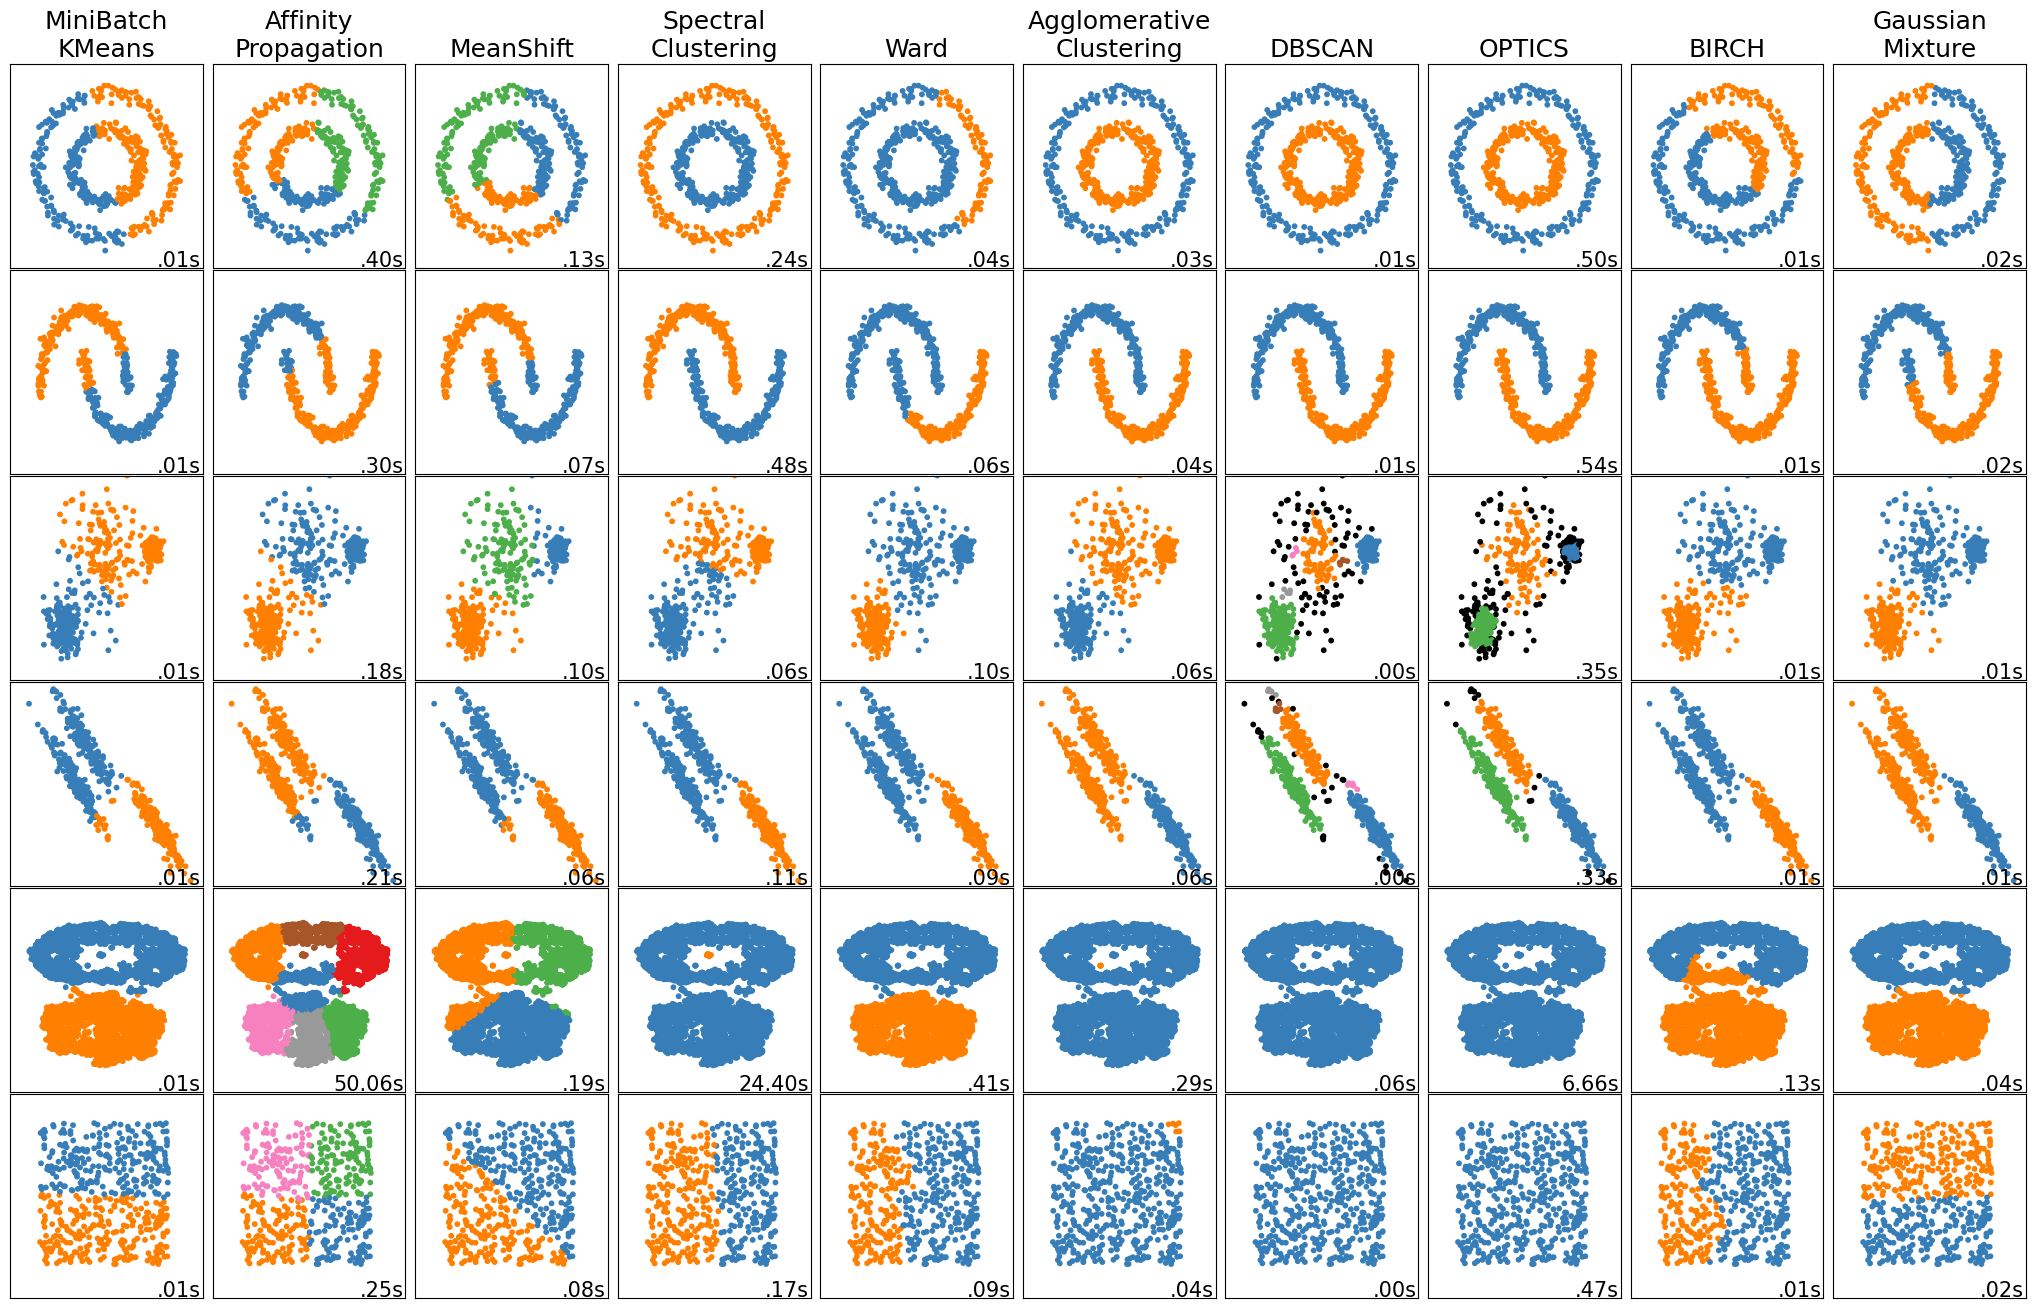

In [ ]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = (data_transformed_2, train_embedding_df.iloc[:, ].to_numpy())
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 2,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": DEFAULT_RANDOM_SEED,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 2400, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans, SpectralClustering, MeanShift, Birch
from sklearn.mixture import GaussianMixture
import numpy as np
from sklearn.datasets import make_blobs

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 2,
    "min_samples": 2400,
    "xi": 0.1,
    "min_cluster_size": 0.2,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": DEFAULT_RANDOM_SEED,
}

# Создаем тестовые данные
blobs = (data_transformed_2, train_embedding_df.iloc[:, ].to_numpy())
# blobs = (/, train_embedding_df.iloc[:, ].to_numpy())

# KMeans
kmeans = KMeans(n_clusters=default_base["n_clusters"], random_state=default_base["random_state"])
kmeans_labels = kmeans.fit_predict(blobs[0])

# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=default_base["n_clusters"])
agg_clustering_labels = agg_clustering.fit_predict(blobs[0])

# DBSCAN
# dbscan = DBSCAN(eps=default_base["eps"], min_samples=default_base["min_samples"])
# dbscan_labels = dbscan.fit_predict(blobs[0])

# Mini Batch KMeans
mini_batch_kmeans = MiniBatchKMeans(n_clusters=default_base["n_clusters"], random_state=default_base["random_state"])
mini_batch_kmeans_labels = mini_batch_kmeans.fit_predict(blobs[0])

# Spectral Clustering
# spectral_clustering = SpectralClustering(n_clusters=default_base["n_clusters"], random_state=default_base["random_state"])
# spectral_clustering_labels = spectral_clustering.fit_predict(blobs[0])

# Gaussian Mixture
gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )
gmm_labels = gmm.fit_predict(blobs[0])

#Mean Shift
# mean_shift = MeanShift()
# mean_shift_labels = mean_shift.fit_predict(blobs[0])

# print("KMeans labels:", (np.array([x for x in kmeans_labels]) == train_embedding_df["y"]).sum())
# print("Agglomerative Clustering labels:", (np.array([x for x in agg_clustering_labels]) == train_embedding_df["y"]).sum())
# print("Mini Batch KMeans labels:", (np.array([x for x in mini_batch_kmeans_labels]) == train_embedding_df["y"]).sum())
# print("Gaussian Mixture labels:", (np.array([x for x in gmm_labels]) == train_embedding_df["y"]).sum())

print("KMeans labels:", ([bin_target_mapper[x] for x in kmeans_labels] == pd.read_csv("/content/summer_school_submit (3).csv")["y"]).sum())
print("Agglomerative Clustering labels:", ([bin_target_mapper[x] for x in agg_clustering_labels] == pd.read_csv("/content/summer_school_submit (3).csv")["y"]).sum())
print("Mini Batch KMeans labels:", ([bin_target_mapper[x] for x in mini_batch_kmeans_labels] == pd.read_csv("/content/summer_school_submit (3).csv")["y"]).sum())
print("Gaussian Mixture labels:", ([bin_target_mapper[x] for x in gmm_labels] == pd.read_csv("/content/summer_school_submit (3).csv")["y"]).sum())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans labels: 4906
Agglomerative Clustering labels: 4936
Mini Batch KMeans labels: 4907
Gaussian Mixture labels: 4907


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


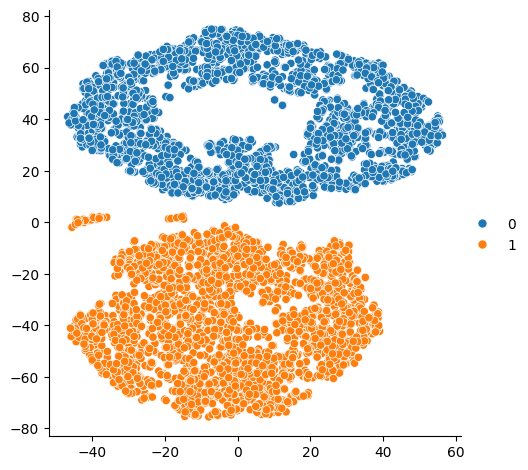

In [ ]:
# визуализация
import seaborn as sns
sns.relplot(x=data_transformed_2[:, 0],
            y=data_transformed_2[:, 1],
            hue=res_train.labels_)

In [ ]:
res_train.labels_

array([1, 0, 0, ..., 0, 1, 1], dtype=int32)

In [ ]:
(np.array([x for x in res_train.labels_]) == train_embedding_df["y"]).sum()

4991

In [ ]:
### knn - 4957
([bin_target_mapper[x] for x in res_test.labels_] == pd.read_csv("/content/summer_school_submit (3).csv")["y"]).sum()

4957

In [ ]:
([bin_target_mapper[x] for x in  res_test.labels_] == pd.read_csv("/content/tta_best_4927_new_20k_submit.csv")["y"]).sum()

4954

In [ ]:
target_bin_mapper = {3 : 0, 8 : 1}
bin_target_mapper = {0 : 3, 1 : 8}
def preprocess_df(df, mode, image_w):

  if mode == "train":
    new_values = df.apply(lambda x: list((x[1:].values.reshape(image_w, image_w)) / 255), axis=1)
    df["image"] = new_values
    return df.iloc[:, [0, -1]]

  else:
    new_values = df.apply(lambda x: list((x.values.reshape(image_w, image_w)) / 255), axis=1)
    df["image"] = new_values
    return df.iloc[:, -1]

train_path = 'https://github.com/afonsky/DataAnalysisSummerSchool-2024/raw/main/trainYX.zip'
test_path = 'https://github.com/afonsky/DataAnalysisSummerSchool-2024/raw/main/testX.zip'
train_df = pd.read_csv(train_path, compression='zip', index_col='id')
test_df = pd.read_csv(test_path, compression='zip', index_col='id')

train_df = preprocess_df(train_df, mode="train", image_w=32)
test_df = preprocess_df(test_df, mode="test", image_w=32)

In [ ]:
from glob import glob

paths = glob("/content/*")

In [ ]:
ys = []
for i in paths[:-1]:
  ys.append(pd.read_csv(i)["y"].to_numpy())
  print((pd.read_csv(i)["y"].to_numpy() == modes).sum())

4983
4980
4983
4977
4989
4986
4951
4953
4968
4960
4989
4964
4981
4978
4962
4958
4981
4935
4982
4951
4958


In [ ]:
from scipy import stats
modes = stats.mode(np.array(ys),axis=0).mode

In [ ]:
submit["y"] = [int(x) for x in list(modes)]

In [ ]:
submit.to_csv("razmetka_new.csv", index=False)

In [ ]:
import pandas as pd
# prognoz = pd.read_csv("/content/prognoz.csv", index_col="Unnamed: 0").sort_values("id").reset_index(drop=True)
submit = pd.read_csv("/content/summer_school_submit_blended.csv")
wrong_samples = pd.read_csv("/content/wrong_samples_test_final.csv")
xuynya_indexes = [19,22,24, 34, 35, 37, 38, 56, 61, 63, 72, 79, 80, 82, 90, 91, 92, 101, 111, 113, 117, 119, 124, 127, 128]

FileNotFoundError: [Errno 2] No such file or directory: '/content/wrong_samples_test_final.csv'

In [ ]:
import numpy as np

new_submit = submit.copy()
for i in wrong_samples["id"]:
  new_submit.loc[new_submit.id == i, "y"] = int(wrong_samples.loc[wrong_samples.id == i, "label"])
  print(new_submit.loc[new_submit.id == i, "y"].values)

<ipython-input-47-caae8a925871>:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  new_submit.loc[new_submit.id == i, "y"] = int(wrong_samples.loc[wrong_samples.id == i, "label"])


[3]
[8]
[3]
[8]
[3]
[8]
[8]
[3]
[8]
[3]
[8]
[8]
[3]
[8]
[3]
[3]
[3]
[8]
[8]
[8]
[8]
[3]
[3]
[8]
[3]
[8]
[3]
[3]
[3]
[3]
[8]
[8]
[8]
[8]
[3]
[8]
[8]
[3]
[8]
[8]
[8]
[8]
[3]
[3]
[3]
[8]
[3]
[3]
[3]
[8]
[8]
[8]
[3]
[3]
[8]
[8]
[3]
[8]
[8]
[8]
[3]
[8]
[3]
[3]
[8]
[3]
[3]
[8]
[8]
[8]
[3]
[8]
[3]
[8]
[8]
[8]
[3]
[3]
[3]
[8]
[8]
[8]
[8]
[3]
[8]
[8]
[3]
[8]
[3]
[8]
[3]
[3]
[3]
[8]
[3]
[3]
[8]
[3]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[3]
[8]
[3]
[8]
[3]
[8]
[3]
[3]
[8]
[8]
[8]
[3]
[8]
[3]
[3]
[8]
[3]
[8]
[3]
[3]
[3]
[8]
[8]
[8]
[3]


In [ ]:
for i in prognoz["id"]:
  new_submit.loc[new_submit.id == i, "y"] = int(prognoz.loc[prognoz.id == i, "y"])
  print(new_submit.loc[new_submit.id == i, "y"].values)

[8]
[8]
[3]
[8]
[3]
[3]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


<ipython-input-48-fc6c69028fd6>:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  new_submit.loc[new_submit.id == i, "y"] = int(prognoz.loc[prognoz.id == i, "y"])


In [ ]:
new_submit.to_csv("model_base.csv", index=False)

In [ ]:
to_3 = [7519,
8387,
9325,
9453,
6389]

for i in to_3:
  new_submit.loc[new_submit.id == i, "y"] = 3
  print(new_submit.loc[new_submit.id == i, "y"])

2519    3
Name: y, dtype: int64
3387    3
Name: y, dtype: int64
4325    3
Name: y, dtype: int64
4453    3
Name: y, dtype: int64
1389    3
Name: y, dtype: int64


In [ ]:
y_pred = submit["y"]

In [ ]:
submit["y"] = y_pred

In [ ]:
new_submit.to_csv("razmetka1.csv", index=False)

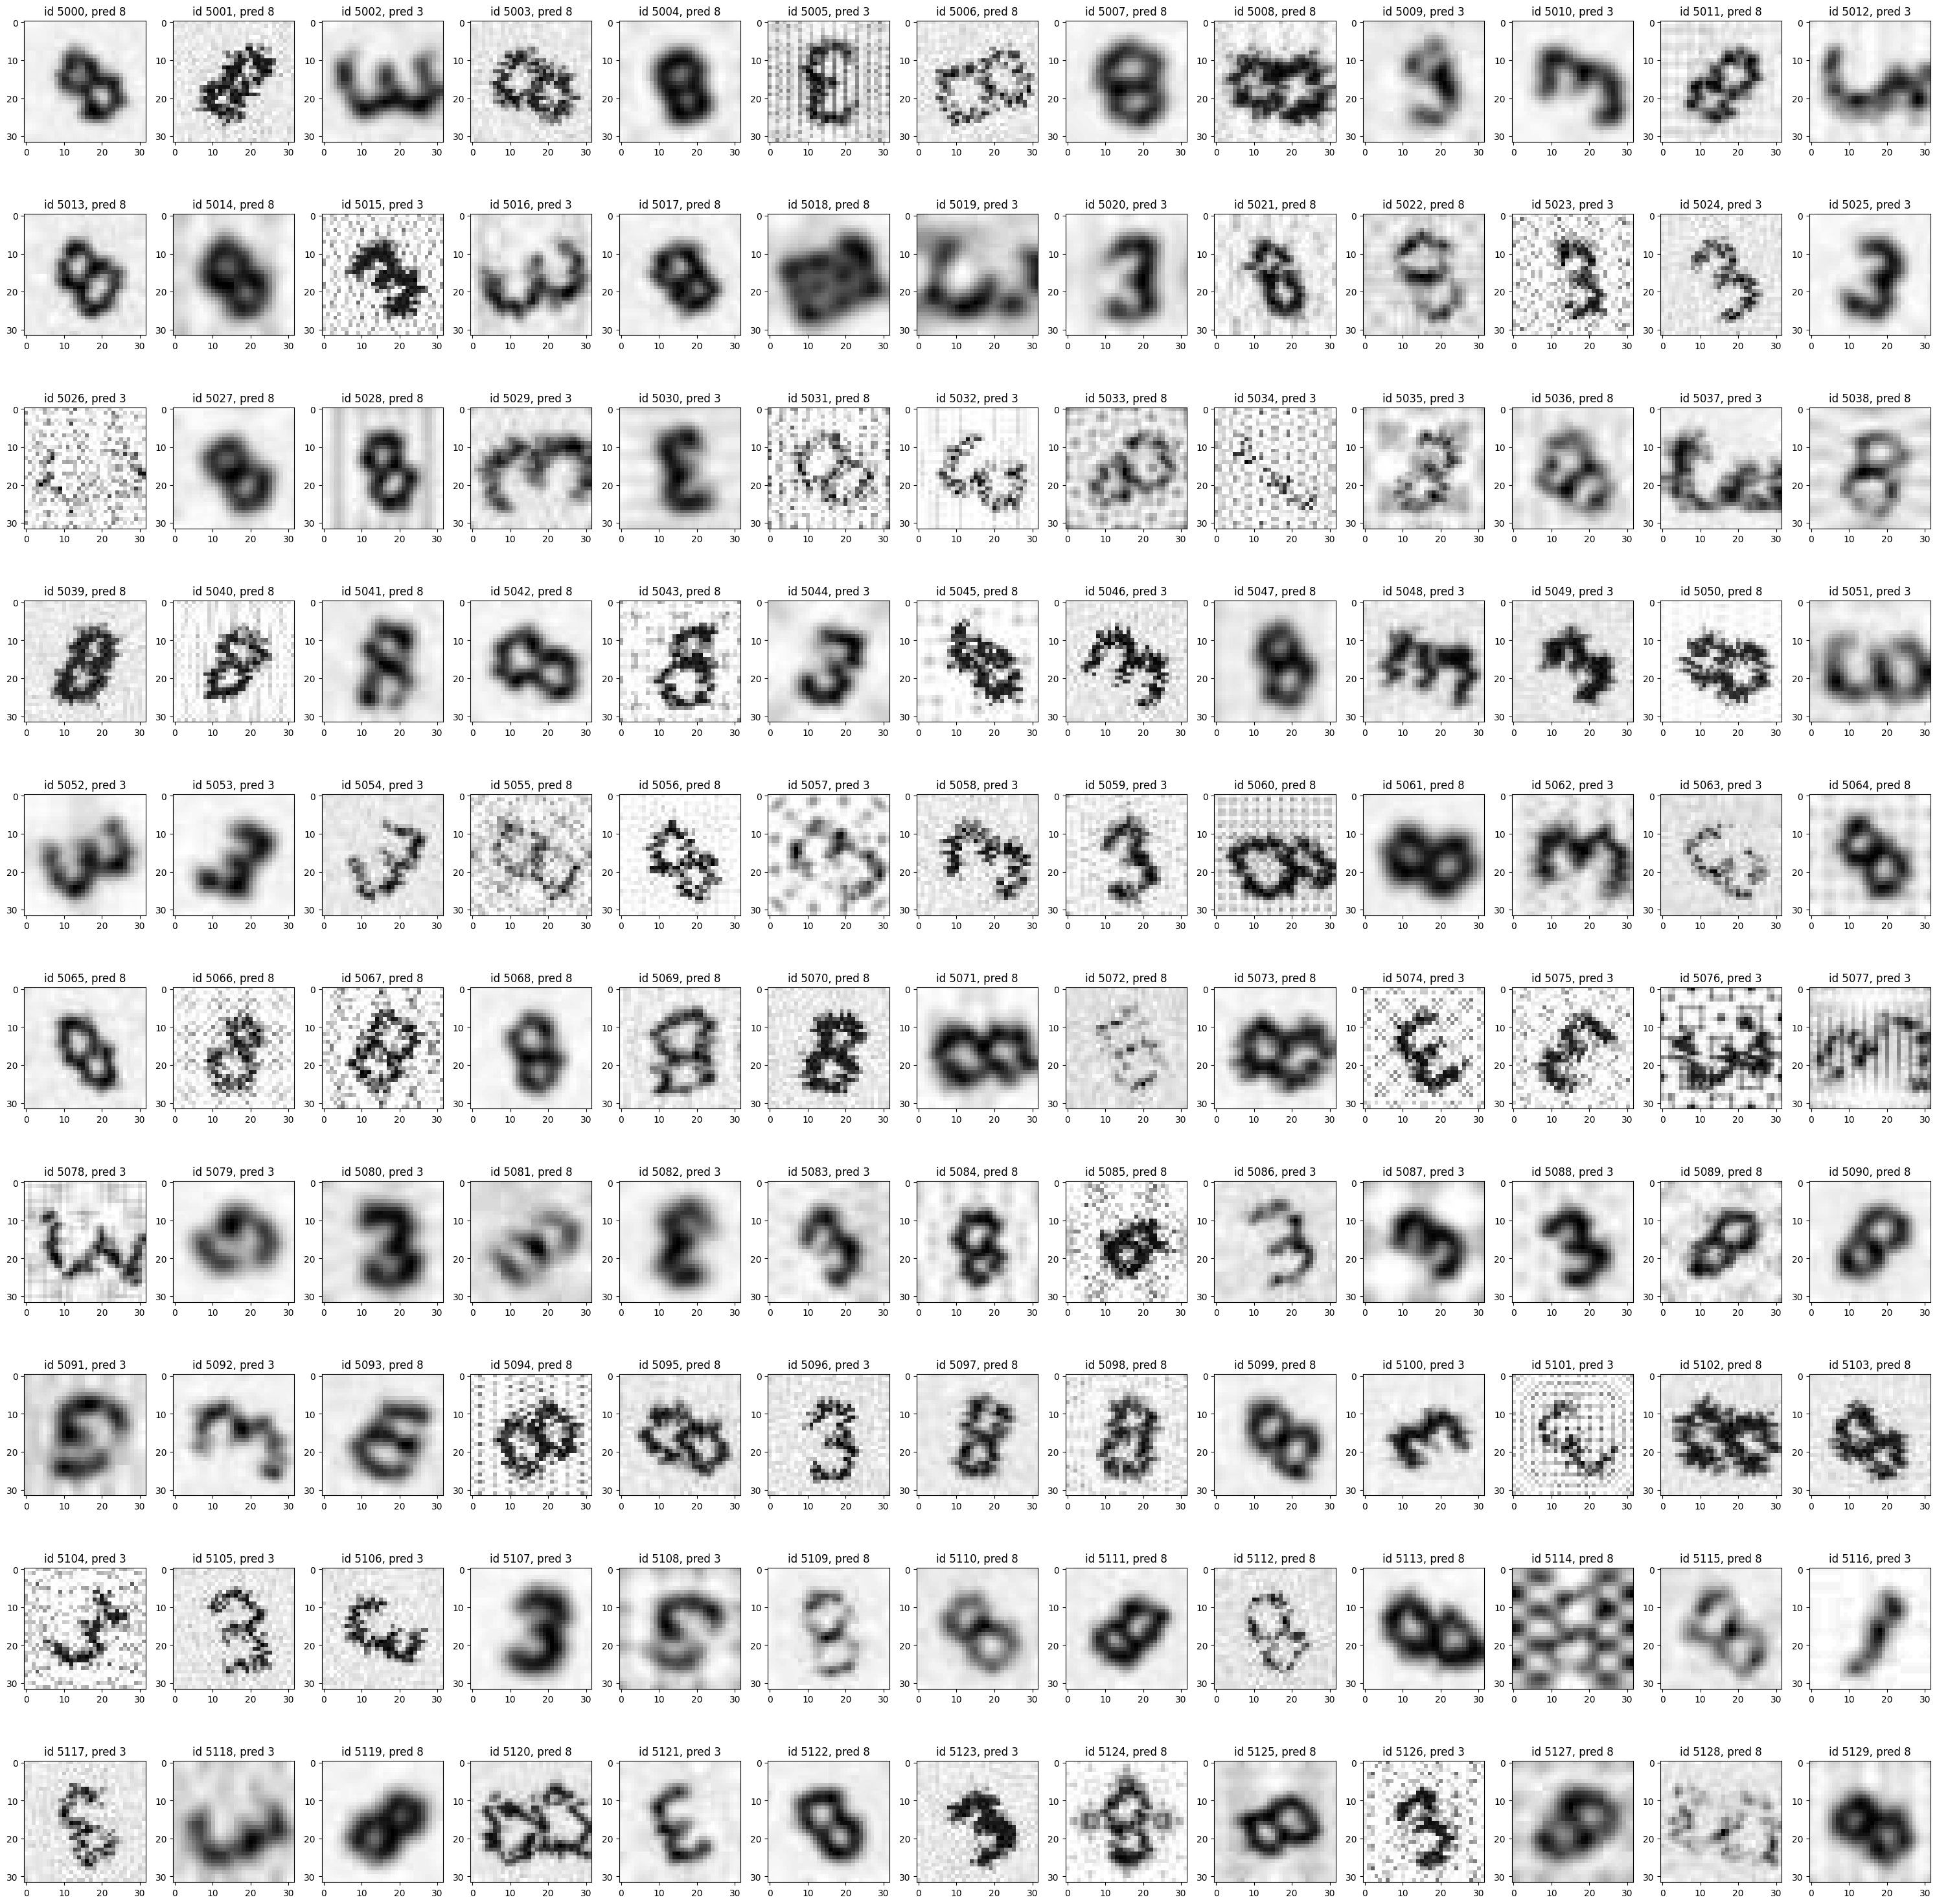

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 30)

n_cols = 13
n_rows = 10
fig, ax = plt.subplots(n_rows, n_cols)
cur_i = 0

for i in range(n_rows):
  for j in range(n_cols):
    ax[i, j].imshow(np.array(test_df.loc[new_submit.iloc[cur_i]['id']]), cmap="gray");
    ax[i, j].set_title(f"id {new_submit.iloc[cur_i]['id']}, pred {new_submit.iloc[cur_i]['y']}");
    cur_i += 1
fig.tight_layout();

### Анализ ошибок модели на валидации

In [ ]:
print(f" 3: {incorrect_stat[1][0]}, {incorrect_stat[1][0]  / (incorrect_stat[1][0] + incorrect_stat[1][1])}%\n---------------------------\n 8: {incorrect_stat[1][1]}, {incorrect_stat[1][1]  / (incorrect_stat[1][0] + incorrect_stat[1][1])}%")

 3: 3, 0.2727272727272727%
---------------------------
 8: 8, 0.7272727272727273%


In [ ]:
plt.rcParams["figure.figsize"] = (20, 20)

n_cols = 3
n_rows = 3
fig, ax = plt.subplots(n_rows, n_cols)

for i in range(n_rows):
  for j in range(n_cols):
    ax[i, j].imshow(incorrect_stat[0][n_rows * i + j][0].cpu(), cmap="gray");
    ax[i, j].set_title(f"label {bin_target_mapper[incorrect_stat[0][n_rows * i + j][1].item()]},\nprob: {round(incorrect_stat[0][n_rows * i + j][2].item(), 3)}");
fig.tight_layout();

### получение предсказаний

In [ ]:
rm = False
if rm:
  for filename in glob("/content/torch_checkpoints/*"):
    os.remove(filename)

In [ ]:
set_all_seeds(DEFAULT_RANDOM_SEED)

@torch.no_grad()
def inference_model(test_loader, model):

  predicted_ids = []
  incorrect = []
  incorrect_count = {0:0, 1:0}

  for (images_orig, aug_1, aug_2, aug_3, aug_4) in tqdm.notebook.tqdm(test_loader):

      images_orig = images_orig.to(device)
      aug_1 = aug_1.to(device)
      aug_2 = aug_2.to(device)
      aug_3 = aug_3.to(device)
      aug_4 = aug_4.to(device)

      outputs_orig = model(images_orig).squeeze()
      probs_orig = F.sigmoid(outputs_orig)

      outputs_aug_1 = model(aug_1).squeeze()
      probs_aug_1 = F.sigmoid(outputs_aug_1)

      outputs_aug_2 = model(aug_2).squeeze()
      probs_aug_2 = F.sigmoid(outputs_aug_2)

      outputs_aug_3 = model(aug_3).squeeze()
      probs_aug_3 = F.sigmoid(outputs_aug_3)

      outputs_aug_4 = model(aug_4).squeeze()
      probs_aug_4 = F.sigmoid(outputs_aug_4)



      coefs = [2, 1, 1, 1, 1]

      outputs = (coefs[0] * outputs_orig + coefs[1] * outputs_aug_1 + coefs[2] *outputs_aug_2 + coefs[3] * outputs_aug_3 + coefs[4] * outputs_aug_4) / sum(coefs)


      preds = torch.zeros(probs_orig.shape)
      preds[probs_orig > 0.5] = 1

      threshold_diffs = torch.abs(probs_orig.cpu() - 0.5)
      mask = np.array(threshold_diffs < 0.3)

      incorrect.extend(list(zip(images_orig[mask], probs_orig[mask], preds[mask])))
      incorrect_count[0] += ((mask) & (preds.cpu().numpy() == 0)).sum().item()
      incorrect_count[1] += ((mask) & (preds.cpu().numpy() == 1)).sum().item()

      predicted_ids.extend(preds.cpu().numpy().tolist())

  return predicted_ids, (incorrect, incorrect_count)

def make_submit(y, sample_submission_path="SampleSubmission.csv"):
  sample_submission = pd.read_csv(sample_submission_path)
  mapper = np.vectorize(lambda x: bin_target_mapper[x])
  sample_submission["y"] = mapper(np.array(y))
  return sample_submission

all seed setted


In [ ]:
# !gdown 1OqsukaAcij6z71t1pfPhMzTqXgMxZz8W
set_all_seeds(DEFAULT_RANDOM_SEED)

if not full_train:
  best_model = torch.load(f'torch_checkpoints/weights_{best_epoch}_{round(best_metric, 5)}.pt')
# else:
#   best_model = model
# best_model=torch.load(f'/content/torch_checkpoints/weights_9_0.991.pt')
# best_model = model
preds, possible_incorrect_stat = inference_model(loaders["test_loader"], best_model)
submit = make_submit(preds)

all seed setted


  0%|          | 0/79 [00:00<?, ?it/s]

### Анализ ошибок в предсказании

In [ ]:
print(f" 3: {possible_incorrect_stat[1][0]}, {possible_incorrect_stat[1][0]  / (possible_incorrect_stat[1][0] + possible_incorrect_stat[1][1])}%\n---------------------------\n 8: {possible_incorrect_stat[1][1]}, {possible_incorrect_stat[1][1]  / (possible_incorrect_stat[1][0] + possible_incorrect_stat[1][1])}%")

 3: 23, 0.3484848484848485%
---------------------------
 8: 43, 0.6515151515151515%


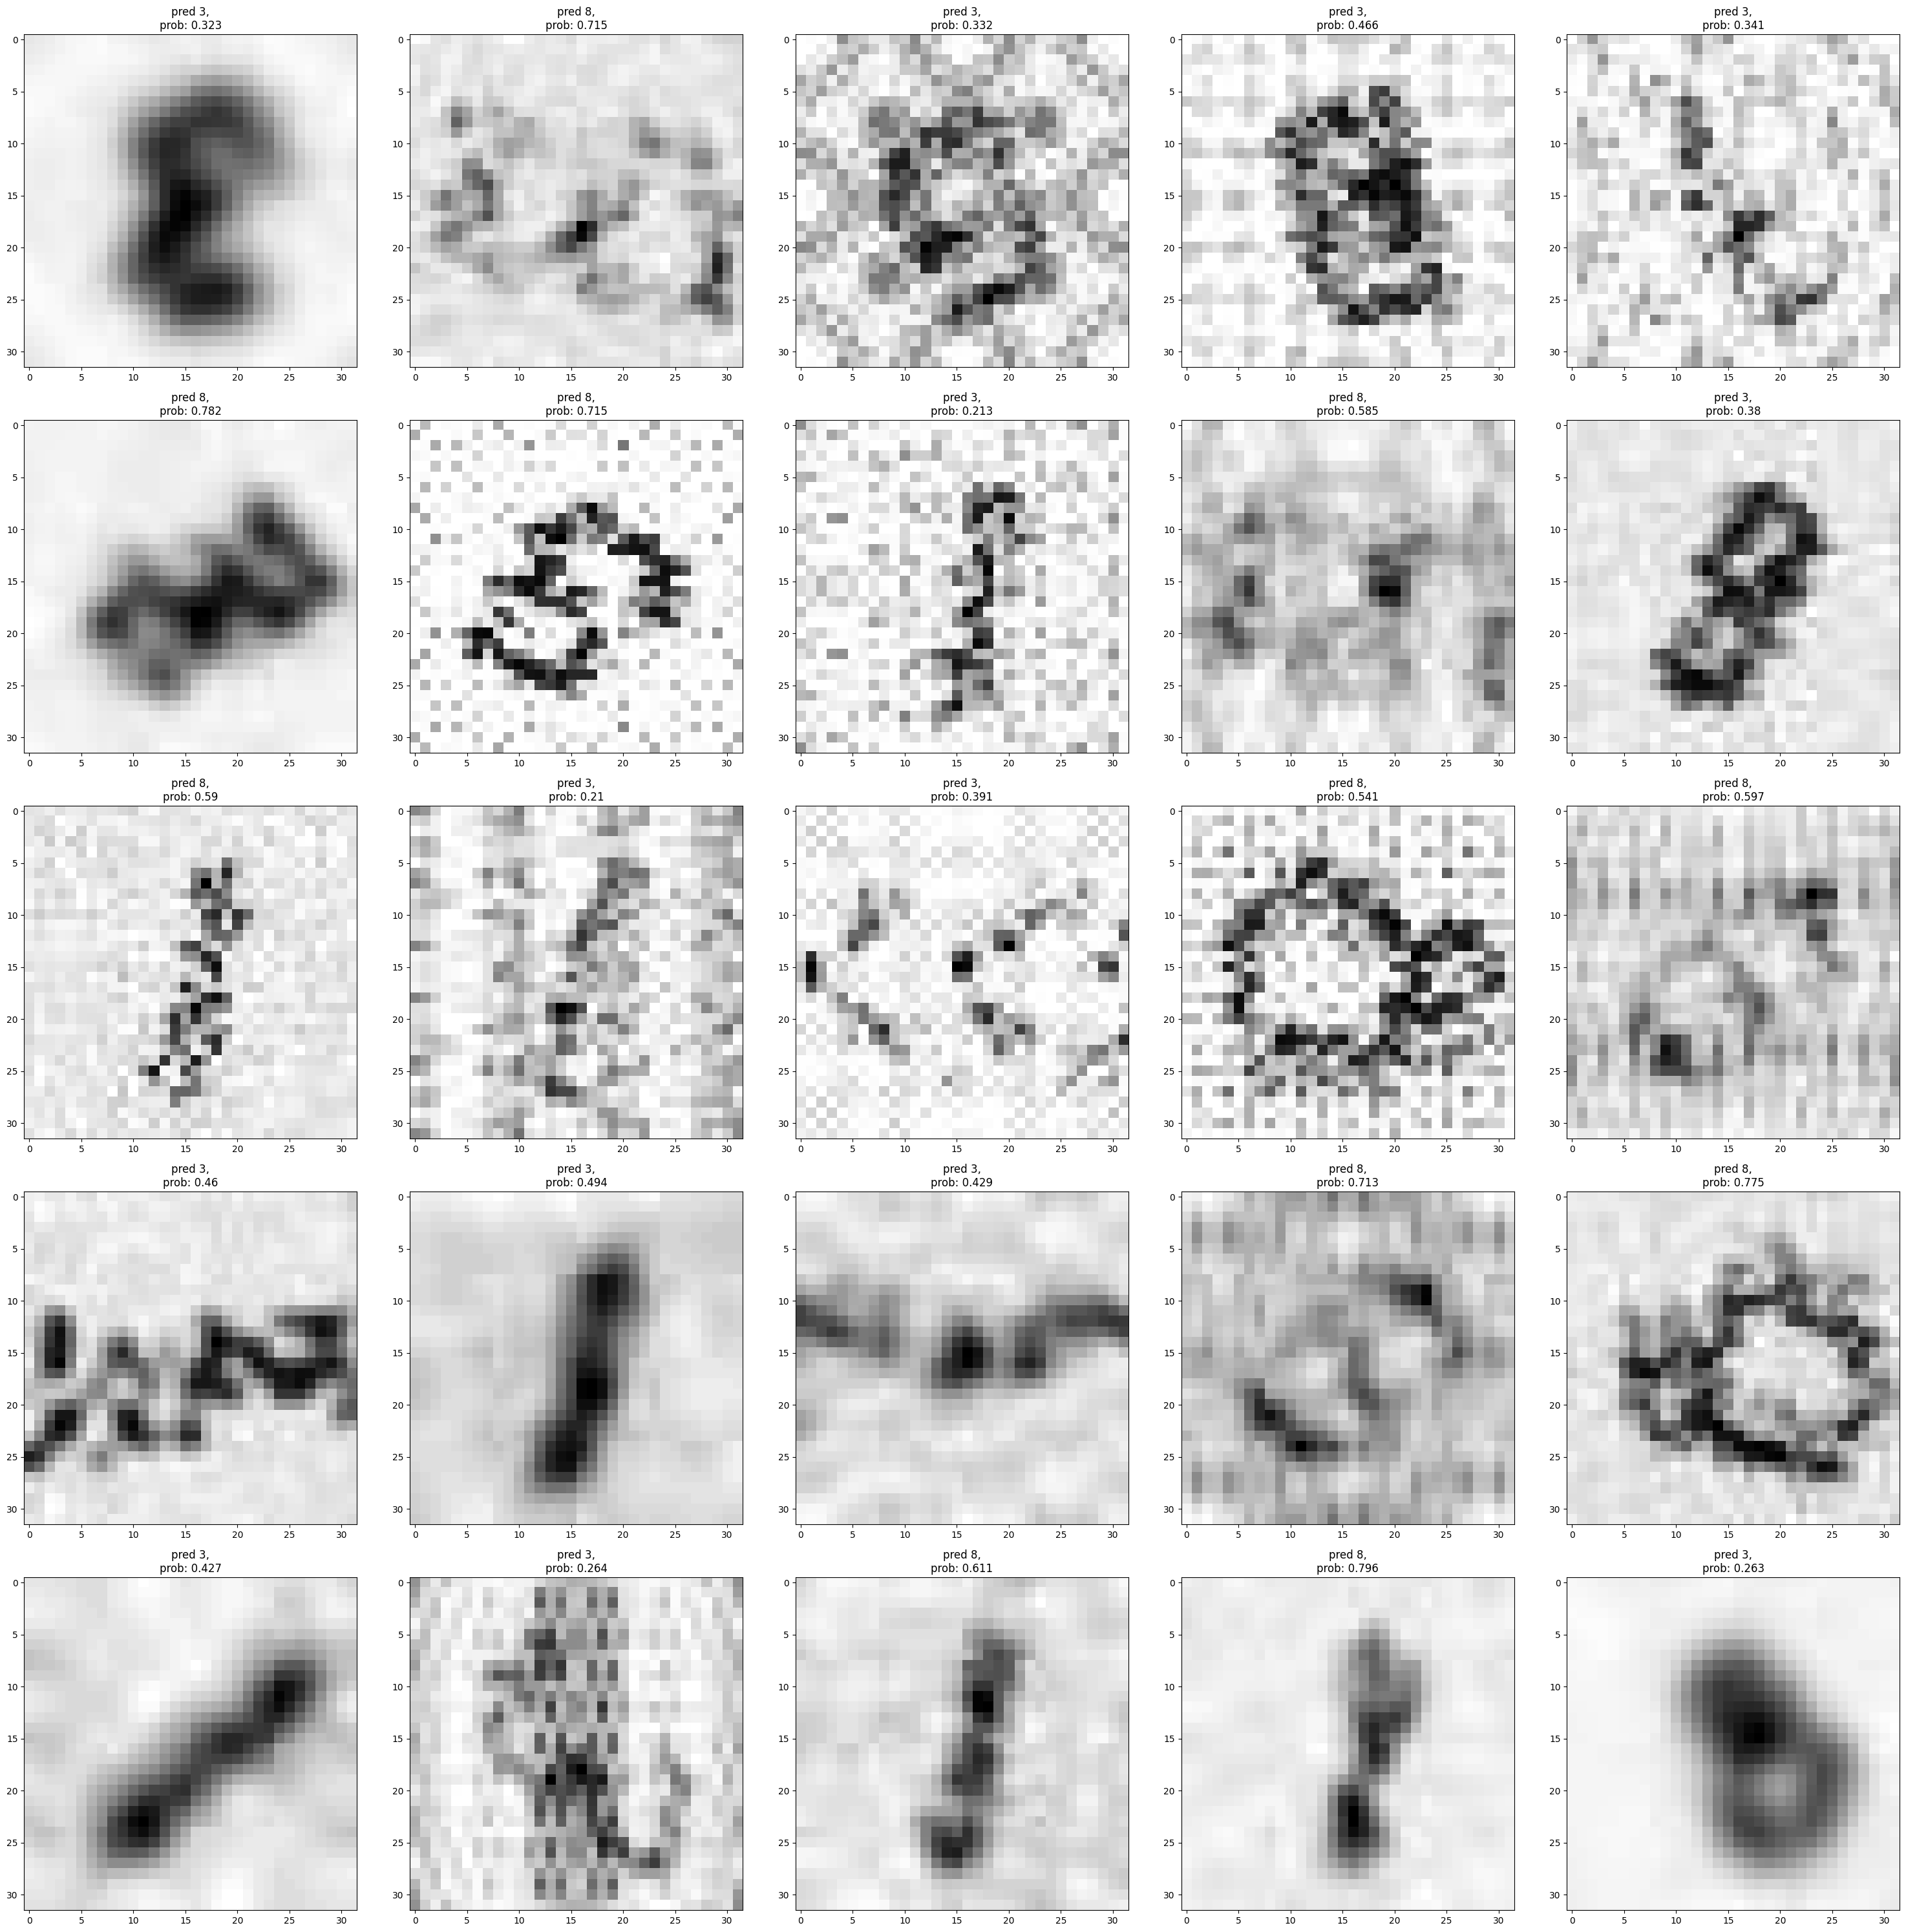

In [ ]:
plt.rcParams["figure.figsize"] = (30, 30)

n_cols = 5
n_rows = 5
fig, ax = plt.subplots(n_rows, n_cols)

for i in range(n_rows):
  for j in range(n_cols):
    ax[i, j].imshow(possible_incorrect_stat[0][n_rows * i + j][0].cpu(), cmap="gray");
    ax[i, j].set_title(f"pred {bin_target_mapper[possible_incorrect_stat[0][n_rows * i + j][2].item()]},\nprob: {round(possible_incorrect_stat[0][n_rows * i + j][1].item(), 3)}");
fig.tight_layout();

In [ ]:
(pd.read_csv("/content/summer_school_submit (3).csv")["y"] == np.array([bin_target_mapper[1-x] for x in res.labels_])).sum()

4931

In [ ]:
# 4954 - 0.993 4, 1.5, 0.6

In [ ]:
(pd.read_csv("/content/tta_best_4927_new_20k_submit.csv")["y"] == submit["y"]).sum()

4959

In [ ]:
correct_x = test_df[np.array(pd.read_csv("/content/summer_school_submit (3).csv")["y"] == submit["y"])].values
correct_y = submit[np.array(pd.read_csv("/content/summer_school_submit (3).csv")["y"] == submit["y"])]["y"].values

plt.rcParams["figure.figsize"] = (30, 30)

n_cols = 13
n_rows = 13
fig, ax = plt.subplots(n_rows, n_cols)

for i in range(n_rows):
  for j in range(n_cols):
    ax[i, j].imshow(correct_x[n_rows * i + j + 1000], cmap="gray");
    ax[i, j].set_title(f"pred {correct_y[n_rows * i + j + 1000]}");
fig.tight_layout();

In [ ]:
submit.to_csv("2_submit.csv", index=False)

In [ ]:
submit["y"].value_counts(normalize=True)

y
3    0.51
8    0.49
Name: proportion, dtype: float64

In [ ]:
extended_train_df["y"].value_counts(normalize=True)

y
8    0.5
3    0.5
Name: proportion, dtype: float64

# Замеряем время

In [ ]:
# if mode is test_mode:
timer.ShowTime()

Время выполнения 40 с


# Использовать позже

In [ ]:
# class MnistTrainWorker:

#   def __init__(self, seed=0, device="cpu")

#     self.seed = seed
#     self.device = torch.device(device)

#   def __init__loaders(self,
#               train_dataset,
#               val_dataset=None,
#               test_dataset=None,
#               batch_size=32,
#               num_workers=None,
#               pin_memory=None):

#     set_all_seeds(self.seed)
#     self.train_loader = DataLoader(train_dataset,
#                                   batch_size=batch_size,
#                                   num_workers=num_workers if (num_workers != None and self.device == torch.device("cuda")) else 0,
#                                   pin_memory=pin_memory if (num_workers != None and self.device == torch.device("cuda")) else False,
#                                   shuffle=True
#                                   )

#     if val_dataset != None:
#       self.val_loader = DataLoader(val_dataset,
#                                   batch_size=batch_size,
#                                   num_workers=num_workers if (num_workers != None and self.device == torch.device("cuda")) else 0,
#                                   pin_memory=pin_memory if (num_workers != None and self.device == torch.device("cuda")) else False,
#                                   shuffle=False
#                                   )

#     if test_dataset != None:
#       self.test_loader = DataLoader(test_dataset,
#                                    batch_size=batch_size,
#                                    num_workers=num_workers if (num_workers != None and self.device == torch.device("cuda")) else 0,
#                                    pin_memory=pin_memory if (num_workers != None and self.device == torch.device("cuda")) else False,
#                                    shuffle=False
#                                    )



#   def train(self, model, num_epochs, optimizer, loss_fn, scheduler, train_fn, val_fn):

#     print("training started")
#     for epoch in tqdm.notebook.trange(num_epochs, desc="epoch loop"):

#       train_fn(train_loader=self.train_loader,  optimizer=optimizer, )
